## Step 4: Analyze contents and give verdict on importance of reading

In [ ]:
import sys
sys.path.append('../')

import asyncio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from components.agents.curator_agent import curate_batch

from data import ContentManager
manager = ContentManager(base_path="../data")

import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

INFO:data.content_manager:Loaded content index with 3387 entries


Get to_pursue items from df

In [2]:
df = pd.read_csv("../data/research_items.csv")

Run in while loop with max attempts to handle remaining errors

In [ ]:
MAX_ATTEMPTS = 7
attempt = 0

while attempt < MAX_ATTEMPTS:
    attempt += 1
    logger.info(f"\n{'='*50}")
    logger.info(f"Attempt {attempt}/{MAX_ATTEMPTS}")
    logger.info(f"{'='*50}")
    
    
    # 1. FILTER
    to_curate = df[
        (
            (df["scout_decision"] == "pursue") & 
            (df["content_loaded_locally"] == True) &
            (df["curated_at"].isna() if "curated_at" in df.columns else True)
        )
        | 
        (df["curator_summary"].str.startswith("ERROR", na=False))
    ]
    
    if len(to_curate) == 0:
        logger.info("✅ All items curated successfully!")
        break
    
    logger.info(f"Curating {len(to_curate)} of {len(df)} items")

    
    # 2. BUILD ITEMS LIST
    items = []
    for _, row in to_curate.iterrows():
        content_info = manager.get(row["url"])
        if content_info and "content_path" in content_info:
            content = Path(content_info["content_path"]).read_text()
            items.append({
                "title": row["title"],
                "source": row["source"],
                "url": row["url"],
                "content": content,
            })
        else:
            logger.info(f"No content for {row['url']}")
    
    if not items:
        logger.info("No valid content found for remaining items")
        break

    
    # 3. RUN CURATION
    analyses = asyncio.run(curate_batch(items, batch_size=30))
    
    # 4. UPDATE DF
    url_to_analysis = {items[i]["url"]: analyses[i] for i in range(len(analyses))}

    for url, analysis in url_to_analysis.items():
        mask = df["url"] == url
        if analysis is None:
            df.loc[mask, "curator_summary"] = "ERROR: Analysis failed"
            df.loc[mask, "curator_takeaways"] = ""
            df.loc[mask, "curator_tags"] = ""
            df.loc[mask, "applicability_score"] = 0
            df.loc[mask, "novelty_score"] = 0
            df.loc[mask, "priority_score"] = 0
            df.loc[mask, "verdict_reasoning"] = "ERROR: Analysis returned None"
            df.loc[mask, "curated_at"] = datetime.now().isoformat()
            continue
        
        df.loc[mask, "curator_summary"] = analysis.summary
        df.loc[mask, "curator_takeaways"] = "\n- ".join([""] + analysis.key_takeaways)
        df.loc[mask, "curator_tags"] = ", ".join(analysis.tags)
        df.loc[mask, "applicability_score"] = analysis.applicability_score
        df.loc[mask, "novelty_score"] = analysis.novelty_score
        df.loc[mask, "priority_score"] = analysis.priority_score
        df.loc[mask, "verdict_reasoning"] = analysis.verdict_reasoning
        df.loc[mask, "curated_at"] = datetime.now().isoformat()    

    
    # 5. CHECK ERRORS
    error_count = len([a for a in analyses if a and a.summary.startswith("ERROR")])

    if error_count == 0:
        logger.info("✅ No errors in this batch!")
        break
    else:
        logger.info(f"⚠️ {error_count} errors remain, retrying...")

else:
    error_count = len([analysis for analysis in analyses if analysis and analysis.summary.startswith("ERROR")])
    logger.error(f"❌ Max attempts ({MAX_ATTEMPTS}) reached, {error_count} errors remain")

INFO:components.agents.curator_agent:Processing batch 1/18 (25 items)



Attempt 1/7
Curating 435 of 5595 items


Curate batch 1/18:   4%|▍         | 1/25 [00:33<13:29, 33.72s/it]INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages?beta=true "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages?beta=true "HTTP/1.1 200 OK"
Curate batch 1/18:  12%|█▏        | 3/25 [00:36<03:38,  9.95s/it]INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages?beta=true "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages?beta=true "HTTP/1.1 200 OK"
Curate batch 1/18:  68%|██████▊   | 17/25 [00:57<00:13,  1.75s/it]INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages?beta=true "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages?beta=true "HTTP/1.1 200 OK"
Curate batch 1/18:  92%|█████████▏| 23/25 [01:01<00:01,  1.24it/s]INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages?beta=true "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/message

✅ No errors in this batch!


Save back to DF once all attempts are exhausted

In [4]:
df.to_csv("../data/research_items.csv", index=False)

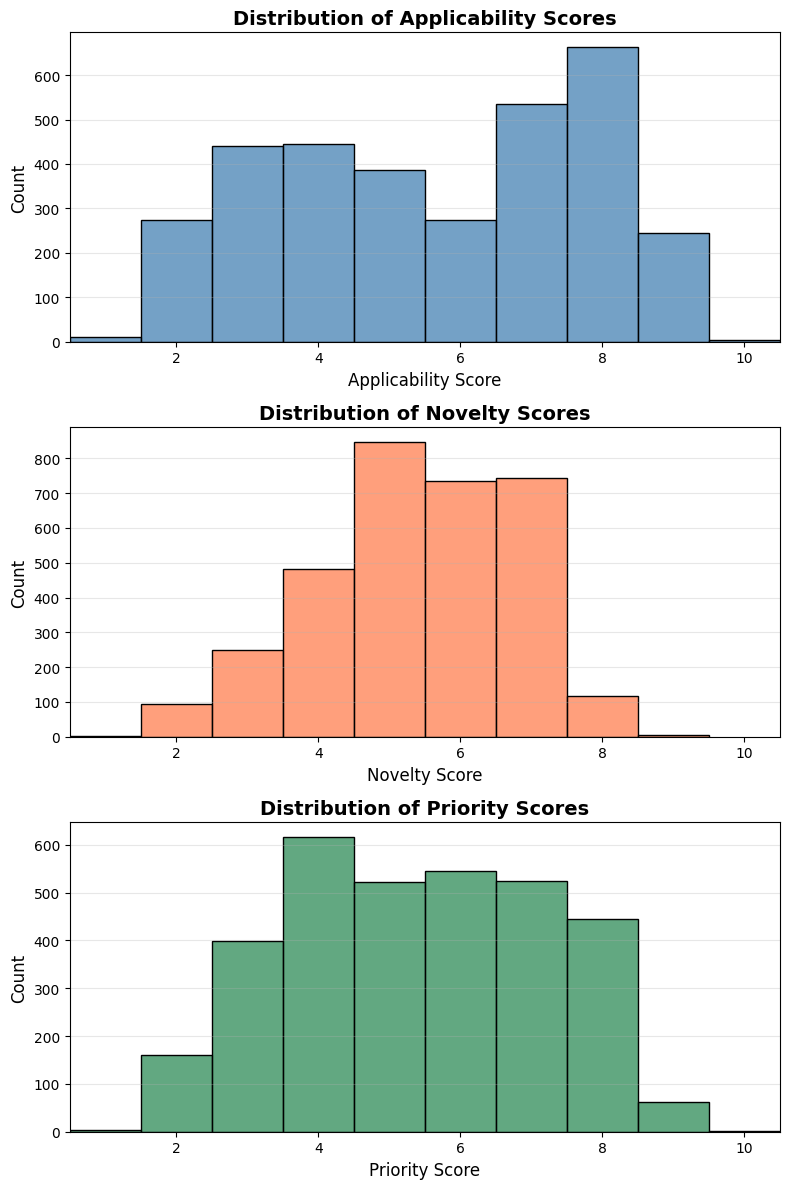

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Applicability Score
sns.histplot(df['applicability_score'].dropna(), bins=range(1, 12), kde=False, ax=axes[0], color='steelblue', discrete=True)
axes[0].set_xlabel('Applicability Score', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Applicability Scores', fontsize=14, fontweight='bold')
axes[0].set_xlim(0.5, 10.5)
axes[0].grid(axis='y', alpha=0.3)

# Novelty Score
sns.histplot(df['novelty_score'].dropna(), bins=range(1, 12), kde=False, ax=axes[1], color='coral', discrete=True)
axes[1].set_xlabel('Novelty Score', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Distribution of Novelty Scores', fontsize=14, fontweight='bold')
axes[1].set_xlim(0.5, 10.5)
axes[1].grid(axis='y', alpha=0.3)

# Priority Score
sns.histplot(df['priority_score'].dropna(), bins=range(1, 12), kde=False, ax=axes[2], color='seagreen', discrete=True)
axes[2].set_xlabel('Priority Score', fontsize=12)
axes[2].set_ylabel('Count', fontsize=12)
axes[2].set_title('Distribution of Priority Scores', fontsize=14, fontweight='bold')
axes[2].set_xlim(0.5, 10.5)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()